In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

#display the first row of measurement table
engine.execute('SELECT * FROM measurement LIMIT 1').fetchall()



[(1, 'USC00519397', '2010-01-01', 0.08, 65.0)]

In [9]:
#display the first row of station table
engine.execute('SELECT * FROM station LIMIT 1').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)



# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

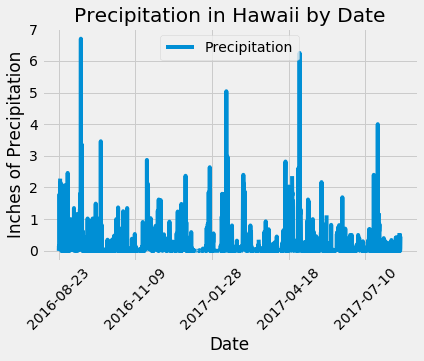

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year_prcp, columns=['date', 'precipitation'])


# Sort the dataframe by date
df.set_index('date')


# Use Pandas Plotting with Matplotlib to plot the data
df.plot('date', 'precipitation')

# Rotate the xticks for the dates
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Inches of Precipitation')
plt.title('Precipitation in Hawaii by Date')
plt.legend(['Precipitation'])
plt.show()






In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.station).count()
total_stations


9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
most_active_station





'USC00519281'

In [35]:
#finding the the lowest, highest, and average temperature of most active station
most_active_station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_station_data

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

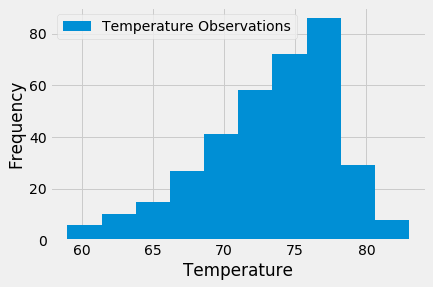

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= last_year).all()

#plotting the results as a histogram
df = pd.DataFrame(last_year_temp, columns=['tobs'])
df.plot.hist()
plt.legend(['Temperature Observations'])
plt.ylabel('Frequency')
plt.xlabel('Temperature')




# Close session

In [18]:
# Close Session
session.close()

In [44]:
#import flask 
from flask import Flask, jsonify
app = Flask(__name__)



In [45]:
#starting at the home page and listing all routes that are available
@app.route("/")

def welcome():
    return (
        f"Welcome to the Climate App API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/start<br/>"
        f"/api/v1.0/start/end<br/>"
    )

In [54]:
@app.route("/api/v1.0/precipitation")
def precipitation_funct():
    #Convert the last_year_prcp query results to a dictionary using date as the key and prcp as the value.
    last_year_prcp_dict = dict(last_year_prcp)
    #Return the JSON representation of your dictionary
    return jsonify(last_year_prcp_dict)
    
    





In [55]:
@app.route("/api/v1.0/stations")
def stations_funct():
    #Return a JSON list of stations from the dataset.
    return jsonify(active_stations)

In [56]:
@app.route("/api/v1.0/tobs")
def tobs_funct():
    #Return a JSON list of Temperature Observations (tobs) for the previous year
    return jsonify(last_year_temp)

In [ ]:
@app.route("/api/v1.0/<start>")
def start_funct(start):
    